# Sentiment Classification - Private Datasets - (Training)

------

**Author:**

- Alan Aboudib:  [Twitter](https://twitter.com/alan_aboudib) | [LinkedIn](https://www.linkedin.com/in/ala-aboudib/) | [Slack](https://app.slack.com/client/T6963A864/DDKH3SXKL/user_profile/UDKH3SH8S)

-----

## Problem Statement

Suppose you run a deep learning company that provides NLP expertise. You have two clients: Bob and Alice. Each of them runs their website where users can write reviews about movies they had watched.

Bob and Alice have heard of the excellent services you provide and ask you to create a sentiment classifier to help them automatically assign a sentiment (positive or negative) to each user's review.

Now you think that this is a really good opportunity. If you pool data from both Bob's and Alice's datasets, you would be able to create a bigger dataset that you can use to train a better classifier.

But... 

It turns out you are not allowed to do this; both datasets are private.

You are informed that privacy regulations in both Bob's and Alice's countries, prevent them from revealing their data to any third party. You cannot move Bob's data to your company's machines. Same for Alice's. Each dataset is constrained to live on its owner's machine, and they cannot be mixed to create a bigger dataset.

Now you think about OpenMined, and their great library called PySyft that provides the possibility to perform Federated Learning and Encrypted Computations. With that, you will be able to train a single model on both datasets at the same time. And YOUR ARE RIGHT!

However, ...

As you know, text datasets cannot be consumed directly for training a neural network. You need to create numerical representations of each text review before the network written with PySyft can consume it. Reviews should first be tokenized, preprocessed, and vector embedding should be used instead of plaintext to train the network. But how to do such preprocessing if you are not allowed to have access to plaintext data? 

**SyferText** can help you! With SyferText, you can define preprocessing components that you can send over a network to Bob's and Alice's machines to perform preprocessing remotely, blindly, and in a completely secure fashion. SyferText components do all the work from processing plaintext to obtaining its vector representation and encrypting it to hand it over to PySyft models for training. All without you accessing the data, and without the data quitting its owner's machine.

If you are wondering how that works, keep on following this tutorial.


**Let's summarize:**

1. You need to create a bigger dataset out of Bob's and Alice's smaller datasets. *(PySyft has the arsenal for that)*

2. You need to prepare and preprocess the text data on Bob's and Alice's machines without revealing it, without moving any datasets to your machine, and without the need to work directly on Bob's or Alice's machines. *(SyferText to the rescue)*

For this tutorial, we are going to work with the IMDB movie review dataset, which is a publically available dataset. But we are going to break it into two parts, send each part to a different PySyft worker. We consider that each part is a private dataset owned by its PySyft worker.

## -4. Importing libraries

Let's first install and import some libraries that we are going to be used all along with this tutorial:

In [ ]:
!pip install -r requirements.txt

In [ ]:
# SyferText imports
import syfertext
from syfertext.pipeline import SimpleTagger

# Import useful utility functions for this tutorial
from utils import download_dataset

# PySyft and PyTorch import
import syft as sy
from syft.generic.string import String
import torch
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim

# Useful imports
import numpy as np
from tqdm import tqdm
import csv
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sb
import os
from pprint import pprint

sb.set()




## -3. Download the Dataset

<div>
    <p style='color:red;'> (IGNORE THIS STEP IF YOU HAVE ALREADY DONE IT) </p>
</div>


The dataset will be downloaded in a folder called `./imdb` in the same directory as the current notebook's. Four files are going to be downloaded:

- `imdb.csv`: This is the dataset file containing 50K labeled reviews. It is a csv file composed of two columns: `review` and `sentiment`. The `review` column holds the review's text, and the `sentiment` column has one of two values: 'positive' or 'negative' to describe the overall sentiment of the review.
- `stop_word_en.txt`: This is just a text file with a list of stop words, according to NLTK.
- `imdb_vocab.txt`: a list of all vocabulary of the dataset. One word per line.
- `imdb_polarity.txt`: It hold the polarity value of each word in `imdb_vocab.txt`. A word that appears more often in positive reviews will have a higher polarity value than one that more frequently encountered in negative reviews.

It is important to note that we consider, for this use case, that only the dataset `imdb.csv` is considered private. All other files in the above list are not under any privacy constraints.

Please run the below cell in order to download the dataset.

In [3]:
# The URL template to all dataset files
url_template = 'https://raw.githubusercontent.com/AlanAboudib/dataset_imdb/master/%s'

# File names to be downloaded from the using the URL template above
files = ['imdb.csv', 'imdb_vocab.txt', 'imdb_polarity.txt', 'stop_word_en.txt']

# Construct the list of urls
urls = [url_template % file for file in files]

# The dataset name and its root folder
dataset_name = 'imdb'
root_path = './imdb'

# Create the dataset folder if it is not already there
if not os.path.exists('./imdb'):
    os.mkdir('./imdb')

# Start downloading
download_dataset(dataset_name = dataset_name, 
                 urls = urls, 
                 root_path = root_path
                )


Preparing to download dataset: `imdb` ...


imdb: 68.0MB [00:34, 1.96MB/s]                              


## -2. Preparing the work environment

As I explained in the introduction, we will simulate a work environment with three main actors, a company (me) and two clients owning two private datasets (Bob and Alice). In PySyft terminology, this translates to creating a worker to represent each actor. We will also need a fourth worker, the crypto provider, which provides the primitives for using Secure Multi-Party Encryption (SMPC) that we will apply to encrypt word embeddings and the model itself before training. Let's create the workers  with PySyft:

In [ ]:
# Create a torch hook for PySyft
hook = sy.TorchHook(torch)

# Create some PySyft workers
me = hook.local_worker # This is the worker representing the deep learning company
bob = sy.VirtualWorker(hook, id = 'bob') # Bob owns the first dataset
alice = sy.VirtualWorker(hook, id = 'alice') # Alice owns the second dataset

crypto_provider = sy.VirtualWorker(hook, id = 'crypto_provider') # provides encryption primitive for SMPC

# Create a summary writer for logging performance with Tensorboard
writer = SummaryWriter()

## -1. Simulating Private Datasets

To simulate two private datasets owned by two different clients, Bob and Alice, we will do the following:

1. Load the whole dataset in `imdb.csv` locally (the `me` worker). This dataset will be loaded as a list of dictionaries that has the following format: `[ {'review': <review text>, 'label': <1 or 0>}, {...}, {...}]`


2. Split the dataset into two parts, one for Bob and the other for Alice. Each part will also be split into a training set and a validation set. This will create four lists: `train_bob`, `valid_bob`, `train_alice`, `valid_alice`. Each list has the same format I mentioned above.


3. Each element in the four lists will be sent to the corresponding worker. This will change the content of the lists, as depicted in **Figure(1)**. Each list will hold PySyft pointers to the texts and labels instead of the objects themselves.

<div>
<br>
<img alt = 'imdb review remote datasets' src ='./art/imdb_review_remote.png' style='width:700px'>
<div>
<div style='width:600px;margin:30px auto 10px auto;text-align:center;'>
<strong> Figure(1): </strong> The reviews and their labels are remotely located on Bob's and Alice's remote machines, only pointers to them are kept by the local worker (the company's machine).
</div>
</div>
<br>
</div>

Let's load the dataset locally:

In [3]:
# Set the path to the dataset file
dataset_path = './imdb/imdb.csv'

# store the dataset as a list of dictionaries
# each dictionary has two keys, 'review' and 'label'
# the 'review' element is a PySyft String
# the 'label' element is an integer with 1 for 'positive'
# and 0 for 'negative' review
dataset_local = []

with open(dataset_path, 'r') as dataset_file:
    
    # Create a csv reader object
    reader = csv.DictReader(dataset_file)
    
    for elem in reader:
        
        # Create one entry
        example = dict(review = String(elem['review']),
                       label = 1 if elem['sentiment'] == 'positive' else 0
                      )
        
        # add to the local dataset
        dataset_local.append(example)

Here is how an element in the list looks like:

In [4]:
example = dataset_local[10]
pprint(example)

{'label': 0,
 'review': 'Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines.<br /><br />At first it was very odd and pretty funny but as the movie progressed I didn\'t find the jokes or oddness funny anymore.<br /><br />Its a low budget film (thats never a problem in itself), there were some pretty interesting characters, but eventually I just lost interest.<br /><br />I imagine this film would appeal to a stoner who is currently partaking.<br /><br />For something similar but better try "Brother from another planet"'}


Let's check out the data types:

In [5]:
print(type(example['review']))
print(type(example['label']))

<class 'syft.generic.string.String'>
<class 'int'>


This review text is a PySyft `String` object. The label is an integer.

Let's split the dataset into two equal parts and send each part to a different worker simulating two remote datasets as I mentioned above:

In [6]:
# Create two datasets, one for Bob, and the other for Alice

dataset_bob, dataset_alice = train_test_split(dataset_local[:25000], train_size = 0.5)

# Now create a validation set for Bob, and another for Alice
train_bob, val_bob = train_test_split(dataset_bob, train_size = 0.7)
train_alice, val_alice = train_test_split(dataset_alice, train_size = 0.7)

And now I will make the dataset remote:

In [7]:
# A function that sends the content of each split to a remote worker
def make_remote_dataset(dataset, worker):

    # Got through each example in the dataset
    for example in dataset:
        
        # Send each review text
        example['review'] = example['review'].send(worker)

        # Send each label as a one-hot-enceded vector
        one_hot_label = torch.zeros(2).scatter(0, torch.Tensor([example['label']]).long(), 1)
        
        # Send the review label
        example['label'] = one_hot_label.send(worker)


Notice that the above function transforms the label into a one-hot-encoded format before sending it to a remote worker. So if the sentiment is negative, the corresponding tensor will hold `[1,0]`, and if it is positive, the label will be `[0,1]`.

I can finally create the remote datasets:

In [8]:
# Bob's remote dataset
make_remote_dataset(train_bob, bob)
make_remote_dataset(val_bob, bob)

# Alice's remote dataset
make_remote_dataset(train_alice, alice)
make_remote_dataset(val_alice, alice)

Let me show you what an element of Bob's dataset look like:

In [9]:
# Take an element from the dataset
example = train_bob[10]

print(type(example['review']))
print(example['label'])

<class 'syft.generic.pointers.string_pointer.StringPointer'>
(Wrapper)>[PointerTensor | me:43565217098 -> bob:62978770308]


Wow, the text type is now a PySyft `StringPointer` that points to the real `String` object  located in Bob's machine. The label type is a PySyft `PointerTensor`. Let's check out the location of the real text and label:

In [10]:
print(example['review'].location)
print(example['label'].location)

<VirtualWorker id:bob #objects:25000>
<VirtualWorker id:bob #objects:25000>


Well, you can see it for yourself, they are located in Bob's machine. This confirms **Figure(1)**.

The datasets are now ready, and so is the work environment. Let's start the fun with SyferText :) 

## 0. Create a `SyferText` Language object

The Language object in SyferText is the master object. It orchestrates all the work done by SyferText. Let's create one:

In [11]:
# Create a Language object with SyferText
nlp = syfertext.load('en_core_web_lg', owner = me)

Whenever you create a Language object as we did above, a pipeline will be created. At initialization, a pipeline only contains a tokenizer. You can see this for yourself using the `pipeline_template` property:

In [12]:
nlp.pipeline_template

[{'remote': True, 'name': 'tokenizer'}]

Notice that the tokenizer entry has a property called `remote` set to `True`. This means that we allow the tokenizer to be sent to a remote worker in case the string to be tokenized live there.

We can add more components to the pipeline by using the `add_pipe` method of the Language class. One component we can add is a `SimpleTagger` object. This is a SyferText object that we can use to set custom attributes to individual tokens. In this tutorial, I will create two such taggers: One that tags tokens that are stop-words, the other tags each token as polar or not. 

By tagging a token, I mean setting a custom attribute to that token and assigning it a given value that we call a `tag`. For example, I set an attribute called `is_stop` with a value `True` for a stop word, and `False` otherwise.

You can refer to **Figure(2)** to see how a pipeline is distributed on multiple workers when the dataset to preprocess is remote.

### 0.1 Create a  tagger for stop words

We will start by creating the stop-word tagger. Let's first load the stop-word file into a list of words:

In [13]:
# Load the list of stop words
with open('./imdb/stop_word_en.txt', 'r') as f:
    stop_words = set(f.read().splitlines())

Now we create the tagger which is an object of the `SimpleTagger` class:

In [14]:
# Create a simple tagger object to tag stop words
stop_tagger = SimpleTagger(attribute = 'is_stop',
                           lookups = stop_words,
                           tag = True,
                           default_tag = False,
                           case_sensitive = False
                          )

Notice that I pass the list of words as the `lookups` arguments. 

Every token in the `Doc` object will be given a custom attribute called `is_stop`. Every time a stop word is found, this attribute will be given the value `True` specified by the `tag` argument of the `SimpleTagger` class initializer, otherwise, the `default_tag` will be used, which I set to `False`.

### 0.2 Create a tagger for most polar words

In the same way, we created a tagger for stop words. We are now going to create another tagger for polar words, i.e., words that are more biased toward a positive or negative sentiment. Let's load the corresponding files `imdb_vocab.txt` and `imdb_polarity.txt`:

In [15]:
# Load the polarity info
with open('./imdb/imdb_vocab.txt', 'r') as f:
    imdb_words = f.read().splitlines()
    
with open('./imdb/imdb_polarity.txt', 'r') as f:
    polarity = [float(line) for line in f.read().splitlines()]

Let me show you the distribution of polarity values:

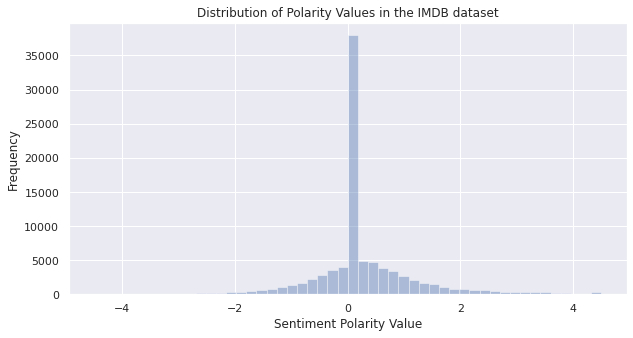

In [16]:
# Create the histogram of polarity values
fig, ax = plt.subplots(figsize = (10,5))
sb.distplot(polarity, kde = False, ax = ax)

ax.set_xlabel('Sentiment Polarity Value')
ax.set_ylabel('Frequency')
ax.set_title("Distribution of Polarity Values in the IMDB dataset");

Notice that the grand majority of words seem to be unbiased toward a specific sentiment. So let's create a tagger that tags only tokens that are most polar by setting a custom attribute we will call `is_polar` to `True` and `False` otherwise:

In [17]:
# Choose low/high polarity cutoff values
low_cutoff = -0.5
high_cutoff = 0.5

# Create a list of polar tokens
polar_tokens = [token for i, token in enumerate(imdb_words) 
                if polarity[i] > high_cutoff or
                polarity[i] < low_cutoff]

Using the list of polar words above, we can now create the tagger:

In [18]:
polarity_tagger = SimpleTagger(attribute = 'is_polar',
                               lookups = polar_tokens,
                               tag = True,
                               default_tag = False,
                               case_sensitive = False
                              )

### 0.3 Adding the taggers to the pipeline

We can now add each tagger we created above to the pipeline by using the `add_pipe()` method of the `Language` class. However, in the next cell, I give you the possibility to decide for yourself which components you wish to add.

Here is what I recommend you do:

1. First, run this tutorial without adding a tagger.

2. Restart the notebook and rerun the tutorial with `use_stop_tagger = True`.

3. Restart the notebook and run the tutorial again with both `use_stop_tagger = True` and `use_polarity_tagger = True`.

I will show you the results of each such run at the end of this notebook.

In [19]:
use_stop_tagger = False
use_polarity_tagger = False

# Tokens with these custom tags
# will be excluded from creating
# the Doc vector
excluded_tokens = {}

Notice that in the above cell. I create a dictionary called `excluded_tokens`. It will be used later in this tutorial when we create embedding vectors for reviews. It enables us to exclude some tokens when we create a document embedding. Such exclusion will be based on the value of the custom attributes we set with the taggers.

Now let's add the stop word tagger to the pipeline (If `use_stop_tagger = True`). Notice that I set the argument `remote = True`. This tells the `Language` object that it is allowed to send the pipe component to the remote worker.

In [20]:
if use_stop_tagger:

    # Add the stop word to the pipeline
    nlp.add_pipe(name = 'stop tagger',
                 component = stop_tagger,
                 remote = True
                )

    # Tokens with 'is_stop' = True are
    # not going to be used when creating the 
    # Doc vector
    excluded_tokens['is_stop'] = {True}

Same for adding the polar word tagger:

In [21]:
if use_polarity_tagger:
    
    # Add the polarity tagger to the pipeline
    nlp.add_pipe(name = 'polarity tagger',
                 component = polarity_tagger,
                 remote = True
                )

    # Tokens with 'is_polar' = False are
    # not going to be used when creating the 
    # Doc vector
    excluded_tokens['is_polar'] = {False}

Let's check out what pipe components are included in the pipeline:

In [22]:
nlp.pipeline_template

[{'remote': True, 'name': 'tokenizer'}]

## 1. Create a Dataset class

Now that we have the remote datasets ready for use, and that SyferText's `Language` object set up with the appropriate pipeline, it's time to create data loaders that will take over the task of creating batches for training and validation.

We will be using regular PyTorch data loaders to accomplish that. 

Each batch will be composed of a mix of training examples coming from both Bob's and Alice's datasets. Actually, for the data loader, there is only one big dataset, it is entirely ignorant of the fact that data is distributed over different workers. 

Each example in the batch contains an encrypted version of one review's embedding vector and its encrypted label. For this tutorial, I compute such a vector as an average of the review's individual token vectors taken from the `en_core_web_lg` language model. Of course, all tokens with custom tags indicated in `excluded_tokens` won't be taken into account in computing a review's vector.

If you look at **Figure(2)** you can see the big picture of how SyferText remotely preprocesses a single review text: 

1. First, the `Language` object `nlp` is used to preprocess one review on Bob's or Alice's machine.
2. The object `nlp` determines that the real review text is actually remote, so it sends a subpipeline containing the required pipeline components we defined to the corresponding worker.
3. The subpipeline is run, and a `Doc` object is created on the remote worker containing the review's individual tokens appropriately tokenized and tagged.
4. On the local worker, a `DocPointer` object is created, pointing to that `Doc` object.
5. By calling `get_encrypted_vector()` on the `DocPointer`, the call is forwarded to `Doc`, which, in turn, computes the `Doc` vector, encrypts it with SMPC using PySyft and returns it to the caller at the local worker.
6. The PyTorch dataloader takes this encrypted vector and appends it to the training or validation batch.

Notice that at no moment in the process, the plaintext data of the remote datasets are revealed to the local worker. *Privacy is preserved thanks to SyferText and PySyft!*

<div>
<br>
<img alt =  'SyferText pipeline' src ='./art/imdb_pipeline.png' style='width:700px;'>
<div>
<p style='width:600px;margin:30px auto 10px auto;text-align:center;'>
<strong> Figure(2): </strong> A pipeline on the local worker only contains pointers to subpipelines carrying out the actual preprocessing on remote workers.
</p>
</div>
<br>
</div>

All of the steps described above, except for *step 6.* are carried out in the `__getitem__()` method of the custom PyTorch `Dataset` object that I define below. Please take a few minutes to check it out below:

In [23]:
class DatasetIMDB(Dataset):
    
    def __init__(self, sets, share_workers, crypto_provider, nlp):
        """Initialize the Dataset object
        
        Args:
            sets (list): A list containing all training OR 
                all validation sets to be used.
            share_workers (list): A list of workers that will
                be used to hold the SMPC shares.
            crypto_provider (worker): A worker that will 
                provide SMPC primitives for encryption.
            nlp: This is SyferText's Language object containing
                the preprocessing pipeline.
        """
        self.sets = sets
        self.crypto_provider = crypto_provider
        self.workers = share_workers
    
        # Create a single dataset unifying all datasets.
        # A property called `self.dataset` is created 
        # as a result of this call.
        self._create_dataset()
        
        # The language model
        self.nlp = nlp
        
    def __getitem__(self, index):
        """In this function, preprocessing with SyferText 
        of one review will be triggered. Encryption will also
        be performed and the encrypted vector will be obtained.
        The encrypted label will be computed too.
        
        Args:
            index (int): This is an integer received by the 
                PyTorch DataLoader. It specifies the index of
                the example to be fetched. This actually indexes
                one example in `self.dataset` which pools over
                examples of all the remote datasets.
        """
        
        # get the example
        example = self.dataset[index]
        
        # Run the preprocessing pipeline on 
        # the review text and get a DocPointer object
        doc_ptr = self.nlp(example['review'])
        
        # Get the encrypted vector embedding for the document
        vector_enc = doc_ptr.get_encrypted_vector(bob, 
                                                  alice, 
                                                  crypto_provider = self.crypto_provider,
                                                  requires_grad = True,
                                                  excluded_tokens = excluded_tokens
                                                 )
        

        # Encrypte the target label
        label_enc = example['label'].fix_precision().share(bob, 
                                                           alice, 
                                                           crypto_provider = self.crypto_provider,
                                                           requires_grad = True
                                                          ).get()


        return vector_enc, label_enc

    
    def __len__(self):
        """Returns the combined size of all of the 
        remote training/validation sets.
        """
        
        # The size of the combined datasets
        return len(self.dataset)

    def _create_dataset(self):
        """Create a single list unifying examples from all remote datasets
        """
        
        # Initialize the dataset
        self.dataset = []
      
        # populate the dataset list
        for dataset in self.sets:
            for example in dataset:
                self.dataset.append(example)
                
    @staticmethod
    def collate_fn(batch):
        """The collat_fn method to be used by the
        PyTorch data loader.
        """
        
        # Unzip the batch
        vectors, targets = list(zip(*batch))

        # concatenate the vectors
        vectors = torch.stack(vectors)
        
        #concatenate the labels
        targets = torch.stack(targets)
        
        return vectors, targets

Let's now create two such `DatasetIMDB` objects, one for training and the other for validation:

In [24]:
# Instantiate a training Dataset object
trainset = DatasetIMDB(sets = [train_bob,
                               train_alice],
                       share_workers = [bob, alice],
                       crypto_provider = crypto_provider,
                       nlp = nlp
                      )

# Instantiate a validation Dataset object
valset = DatasetIMDB(sets = [val_bob,
                             val_alice],
                     share_workers = [bob, alice],
                     crypto_provider = crypto_provider,
                     nlp = nlp
                    )

## 2. Create a DataLoader

Let's now choose some hyper parameters for training and validation, and create the PyTorch data loaders:

In [25]:
# Set some hyper parameters
learning_rate = 0.001
batch_size = 32
epochs = 1

In [26]:
# Instantiate the DataLoader object for the training set
trainloader = DataLoader(trainset, shuffle = True,
                         batch_size = batch_size, num_workers = 0, 
                         collate_fn = trainset.collate_fn)


# Instantiate the DataLoader object for the validation set
valloader = DataLoader(valset, shuffle = True,
                       batch_size = batch_size, num_workers = 0, 
                       collate_fn = valset.collate_fn)



## 3. Create an Encrypted Classifier

The sentiment classifier I use here is simply a linear layer with `300` input features, which is the size of the embedding vectors computed by SyferText. A ReLU activation is then applied. The network has two outputs, one for negative sentiments and the other for positive ones.

In [27]:
class Classifier(torch.nn.Module):
    
    def __init__(self, in_features, out_features):
        super(Classifier, self).__init__()
        
        self.fc = torch.nn.Linear(in_features, out_features)
                
    def forward(self, x):
        
        logits = self.fc(x)
        
        probs = F.relu(logits)
        
        return probs, logits

I should now initialize and encrypt the classifier. Encryption here should, of course, use the same workers to hold the shares and the same primitives used to encrypt the document vectors.

In [28]:
# Create the classifer
classifier = Classifier(in_features = 300, out_features = 2)

# Apply SMPC encryption
classifier = classifier.fix_precision().share(bob, alice, 
                                              crypto_provider = crypto_provider,
                                              requires_grad = True
                                              )
print(classifier)


Classifier(
  (fc): Linear(in_features=300, out_features=2, bias=True)
)


/home/alan/miniconda3/envs/syfertext/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/additive_shared.py:72: UserWarning: Use dtype instead of field
  warnings.warn("Use dtype instead of field")
/home/alan/miniconda3/envs/syfertext/lib/python3.7/site-packages/syft/frameworks/torch/tensors/interpreters/additive_shared.py:84: UserWarning: Default args selected
  warnings.warn("Default args selected")


And finally, I create an optimizer. Notice that the optimizer does not need to be encrypted since it operates separately within each worker holding the classifier's and embeddings' shares. We need to make it operate on fixed precision numbers that are used to encode shares.

In [29]:
optim = optim.SGD(params = classifier.parameters(),
                  lr = learning_rate)

optim = optim.fix_precision()

## 4. Start training

Woohoo!!! You are now ready to launch training. 

Notice that we use MSE as a training loss, which is not the best choice for a classification task. I choose to use it since the `NLLLoss()` is not yet implemented in PySyft for SMPC mode. But it is an issue that is currently being worked on.

To view the training and validation curves for loss and accuracy, you need to run `Tensorboard`. Just open a terminal, navigate to the folder containing this notebook, and run:

```
$ tensorboard --logdir runs/
```

Then open your favorite web browser and go to `localhost:6006`.

The below cell will produce no outputs. But you be able to see performance curves on Tensorboard.

In [ ]:
for epoch in range(epochs):
    
    for iter, (vectors, targets) in enumerate(trainloader):
        
        # Set train mode
        classifier.train()

        # Zero out previous gradients
        optim.zero_grad()

        # Predict sentiment probabilities
        probs, logits = classifier(vectors)

        # Compute loss and accuracy
        loss = ((probs -  targets)**2).sum()


        # Get the predicted labels
        preds = probs.argmax(dim=1)
        targets = targets.argmax(dim=1)
        
        # Compute the prediction accuracy
        accuracy = (preds == targets).sum()
        accuracy = accuracy.get().float_precision()
        accuracy = 100 * (accuracy / batch_size)
        
        # Backpropagate the loss
        loss.backward()

        # Update weights
        optim.step()

        # Decrypt the loss for logging
        loss = loss.get().float_precision()

        
        # Log to Tensorboard
        writer.add_scalar('train/loss', loss, epoch * len(trainloader) + iter )
        writer.add_scalar('train/acc', accuracy, epoch * len(trainloader) + iter )

        
        """ Perform validation on exactly one batch """
        
        # Set validation mode
        classifier.eval()

        for vectors, targets in valloader:
            
            probs, logits = classifier(vectors)

            loss = ((probs -  targets)**2).sum()

            preds = probs.argmax(dim=1)
            targets = targets.argmax(dim=1)

            accuracy = preds.eq(targets).sum()
            accuracy = accuracy.get().float_precision()
            accuracy = 100 * (accuracy / batch_size)

            loss = loss.get().float_precision()
            
            
            # Log to tensorboard
            writer.add_scalar('val/loss', loss, epoch * len(trainloader) + iter )
            writer.add_scalar('val/acc', accuracy, epoch * len(trainloader) + iter )
            
            break

            
writer.close()

Now that training is finished, let me prove to you that as I explained in **Figure(2)**, both Bob and Alice have `SubPipeline` objects on their machines sent by SyferText that contain the pipeline components I defined above. Just run the following cells.

In [31]:
# On bob's machine
[bob._objects[id] for id in bob._objects if  isinstance(bob._objects[id], syfertext.SubPipeline)]

[SubPipeline[tokenizer]]

In [32]:
# On Alices's machine
[alice._objects[id] for id in alice._objects if  isinstance(alice._objects[id], syfertext.SubPipeline)]

[SubPipeline[tokenizer]]

## 5. Results

Now you can go back to section `0.3 Adding the taggers to the pipeline` and add a stop word tagger or a polar word tagger (or both) and launch a new training to check out the performance.

You can see from figure (3) below that I obtained the best performance (for 1 epoch) when I excluded stop-words and non-polar words. The worst performance was obtained when no taggers were used.

<div>
<br>
    <img alt =  'Accuracy curves' src ='./art/sentiment_accuracy.png' style='width:1000px;height:400px;'>
<div>
<p style='width:600px;margin:30px auto 10px auto;text-align:center;'>
<br>
<strong> Figure(3): </strong> Evolution of training and validation accuracy scores for 3 different configurations of the preprocessing pipeline: with no taggers, with a stop word tagger with stop word exclusion when creating document vectors, and with the stop word tagger followed by a word-polarity tagger.
</p>
</div>
<br>
</div>

### Next Steps <3

You might be wondering about how to bundle the model you just trained and add it to SyferText's pipelines to use for later inference? This is work in progress, and a tutorial on this is coming soon, so stay tuned ;)

### Congratulations!

You have successfully used SyferText and PySyft to train a Sentiment Classifier trained on multiple private datasets. For this use case, we have used a public dataset and simulated a situation where the datasets are considered remote and private. But this is pretty much how SyferText is being built to be used with real private datasets.

If you enjoyed this use case, stay tuned, more compelling use cases are on the way. You can follow me on [twitter](https://twitter.com/alan_aboudib) to get updates about SyferText. 

You can also contribute to building SyferText with our fantastic team by checking out our [GitHub issues](https://github.com/OpenMined/SyferText/issues) or suggesting a new use case around SyferText.